## Задание

    1. Скачайте текст произведения «Война и мир»: ссылка на GitHub и Google Drive.
    2. Очистите его, оставив только русские буквы и символы пробела.
    3. Постройте матрицу переходных вероятностей.
    4. Посчитайте вероятность встретить строку из четырёх символов, которая начинается на букву «П» и заканчивается на букву «Р».
    5. Используя матрицу переходных вероятностей, сгенерируйте слово, начинающееся с буквы «Б» длиной восемь символов.
    6. Выберите ряд из предыдущих домашних заданий по временным рядам и оцените его через HMM.
    7. Попробуйте построить через среднее каждой компоненты наивный прогноз ряда.


#### 1. Подготовка

In [1]:
# загрузка библиотек
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm.auto import tqdm
%matplotlib inline
sns.set()
from hmmlearn.hmm import GaussianHMM

In [2]:
# функция для преобразования текста
regex = re.compile("[а-я ё]+") # букву ё пришлось указать отдельно, в стандартном виде регулярные выражения её выкидывали
def words_only(text, regex=regex):
    try:
        return " ".join(regex.findall(text))
    except:
        return ""

In [3]:
# вспоминаю регулярные выражения
# как ни странно, работает
text = "Слово слова МнОго ё букВ12 12.  Too many leTters."
text = text.lower()
text
words_only(text)

'слово слова много ё букв         '

### 1. - 2. Загружаю и очищаю текст

In [4]:
text = ""
for i in range(1, 5):
    with open(f'Data/tom_{i}.txt', 'r') as f:
        tom = f.read().lower()
    
    text = text + words_only(tom) + " "
text[:100]

'лев толстой война и мир том      том  часть первая часть  орая часть третья     том  лев николаевич '

### 3. Строю матрицу переходных вероятностей

In [5]:
# русские буквы и их порядковые номера в алфавите
RUSSIAN = 'абвгдеёжзийклмнопрстуфхцчшщъыьэюя '
POS_RU = {l: i for i, l in enumerate(RUSSIAN)}

In [6]:
# нулевая матрица вероятностей
probabilities_ru = np.zeros((len(RUSSIAN), len(RUSSIAN)))

In [7]:
# объединяю символы и заполняю матрицу
for cp, cn in zip(text[:-1], text[1:]):
    probabilities_ru[POS_RU[cp], POS_RU[cn]] += 1

In [8]:
# рассчитываю вероятности совместного пересечения букв
probabilities_ru = (probabilities_ru / probabilities_ru.sum(axis=1)[:, None])

In [9]:
# создаю датафрейм с вероятностями
df = pd.DataFrame(probabilities_ru, index=(c for c in RUSSIAN), columns=(c for c in RUSSIAN))

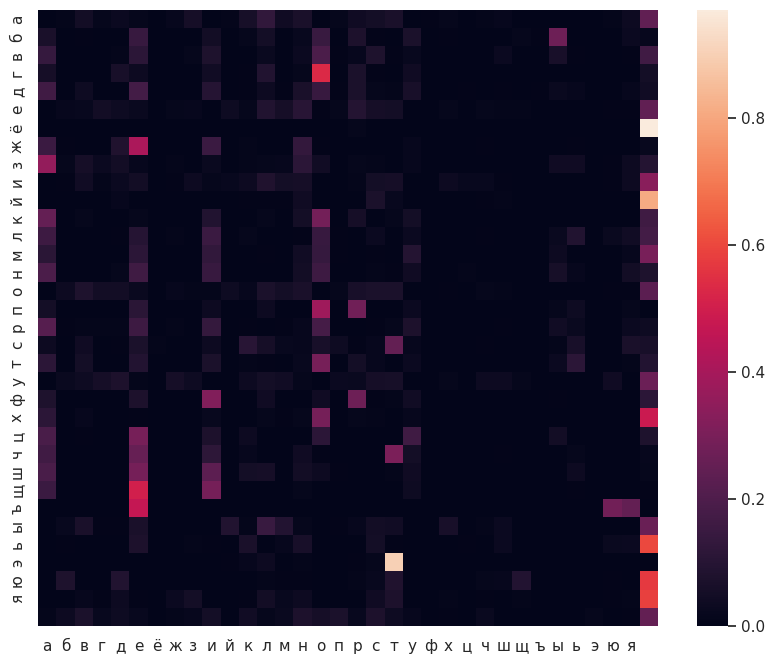

In [10]:
# строю матрицу
plt.figure(figsize=(10,8))
sns.heatmap(df, xticklabels=list(RUSSIAN), yticklabels=list(RUSSIAN))
plt.show()

### 4. Посчитайте вероятность встретить строку из четырёх символов, которая начинается на букву «П» и заканчивается на букву «Р».

In [11]:
# функция, которая возвращает вероятность совместного пересечения букв
def get_letter_and_prob(prev_letter=None, alfabet=RUSSIAN, probabilities=probabilities_ru, POS=POS_RU):
    if prev_letter is None:
        for s in list(alfabet):
            yield s, probabilities[POS[' '], POS[s]]
    else:
        for s in list(alfabet):
            yield s, probabilities[POS[prev_letter], POS[s]]

In [12]:
words = []
s1 = 'п'
s4 = 'р'
p1 = 1./len(RUSSIAN)
for s2, p2 in get_letter_and_prob(s1):
    for s3, p3 in get_letter_and_prob(s2):
        p4 = probabilities_ru[POS_RU[s3], POS_RU[s4]]
        words.append((s1 + s2 + s3 + s4, p1 * p2 * p3 * p4))

In [13]:
# все слова, начинающиеся с "п" и заканчивающиеся на "р"
words = sorted(words, key = lambda w: w[1], reverse=True)
words[:20]

[('прер', 0.00011972957249743935),
 ('прор', 9.090146575431442e-05),
 ('прар', 7.408666164492923e-05),
 ('по р', 4.9459361869226094e-05),
 ('потр', 4.0618381135291435e-05),
 ('попр', 3.982119681522803e-05),
 ('погр', 3.829872254914047e-05),
 ('подр', 3.803482432654819e-05),
 ('побр', 2.914962805316165e-05),
 ('поер', 2.57277837351067e-05),
 ('прур', 1.5237213174379196e-05),
 ('пе р', 1.5076146744146271e-05),
 ('повр', 1.418838077439201e-05),
 ('пь р', 1.270665867994666e-05),
 ('пепр', 1.174654443212205e-05),
 ('пегр', 1.106227655680541e-05),
 ('прир', 9.714444308635858e-06),
 ('покр', 9.705139169185005e-06),
 ('пофр', 8.930758404839307e-06),
 ('петр', 8.743481180032835e-06)]

In [14]:
# общая сумма вероятности
prob = sum([w[1] for w in words])
prob

0.0009128324183391966

In [15]:
# тренировка
probabilities_ru[POS_RU['э'], POS_RU['т']]

0.8993764172335601

 ### 5. Используя матрицу переходных вероятностей, сгенерируйте слово, начинающееся с буквы «Б» длиной восемь символов.

In [16]:
# функция, генерирующая слово
def gen_word(start='б', length=8):
    word = start
    prev_letter = start
    for i in range(length-1):
        while True: # Альтернатива циклу - подсовывать алфавит без пробела и пересчитать вероятности
            next_letter = np.random.choice(list(RUSSIAN), p=probabilities_ru[POS_RU[prev_letter]])
            if next_letter != ' ': # пробел внутри слова - весьма странно
                word += next_letter
                prev_letter = next_letter
                break
    
    # последняя буква должна выбираться с учетом пробела после слова
    probas = []
    letters = []
    for l in RUSSIAN[:-1]:
        proba = probabilities_ru[POS_RU[prev_letter], POS_RU[l]] * probabilities_ru[POS_RU[l], POS_RU[' ']]
        if proba > 0:
            probas.append(proba)
            letters.append(l)
    
    probas = probas / sum(probas)
    word += np.random.choice(letters, p=probas)
    
    return word

In [17]:
[gen_word() for _ in range(20)]

['быспокаяж',
 'биносткоя',
 'бойнилиже',
 'ботойская',
 'бымускрик',
 'быткукаше',
 'беоваячть',
 'брелитого',
 'бнихдакот',
 'бывсренцо',
 'бамитозая',
 'бнузихоей',
 'бонетьейт',
 'бллогриво',
 'быбыннеть',
 'бщадалдой',
 'ботраконы',
 'блколязей',
 'брощискую',
 'бельмийня']

### 6. Выберите ряд из предыдущих домашних заданий по временным рядам и оцените его через HMM.

In [18]:
# возьму ряд с авиаперевозками как самый зловредный из первой ДЗ
series = pd.read_csv("../HW_1_Временные_ряды_общая_теория/Series/international-airline-passengers.csv")['Count']
values = series.values.reshape(-1,1)

In [19]:
scores = []
for n in tqdm(range(1, 30)):
    model = GaussianHMM(n_components=n,
                        covariance_type="diag",
                        n_iter=1000)
    model.fit(values)
    scores.append((n, model.score(values)))

  0%|          | 0/29 [00:00<?, ?it/s]

Fitting a model with 167 free scalar parameters with only 144 data points will result in a degenerate solution.
Fitting a model with 194 free scalar parameters with only 144 data points will result in a degenerate solution.
Fitting a model with 223 free scalar parameters with only 144 data points will result in a degenerate solution.
Fitting a model with 254 free scalar parameters with only 144 data points will result in a degenerate solution.
Fitting a model with 287 free scalar parameters with only 144 data points will result in a degenerate solution.
Fitting a model with 322 free scalar parameters with only 144 data points will result in a degenerate solution.
Fitting a model with 359 free scalar parameters with only 144 data points will result in a degenerate solution.
Fitting a model with 398 free scalar parameters with only 144 data points will result in a degenerate solution.
Fitting a model with 439 free scalar parameters with only 144 data points will result in a degenerate so

In [20]:
scores

[(1, -893.1837902090575),
 (2, -803.8479626176518),
 (3, -764.7871057130568),
 (4, -780.0843097123254),
 (5, -781.11498389067),
 (6, -730.9938552750418),
 (7, -725.7745433206544),
 (8, -704.3867346695573),
 (9, -721.5403513999133),
 (10, -745.2817706486692),
 (11, -706.1476539689289),
 (12, -664.6497729251274),
 (13, -702.219344771292),
 (14, -665.4320176369348),
 (15, -662.6662479091505),
 (16, -665.2063669918153),
 (17, -698.1891740506599),
 (18, -648.6940562121869),
 (19, -671.3339486735633),
 (20, -650.1914255975471),
 (21, -658.7490622706722),
 (22, -644.447927491948),
 (23, -641.108046342786),
 (24, -616.4285751633768),
 (25, -646.2742579073383),
 (26, -643.3760232231056),
 (27, -616.9386891982364),
 (28, -615.3663220730442),
 (29, -633.9906306071556)]

Fitting a model with 439 free scalar parameters with only 144 data points will result in a degenerate solution.


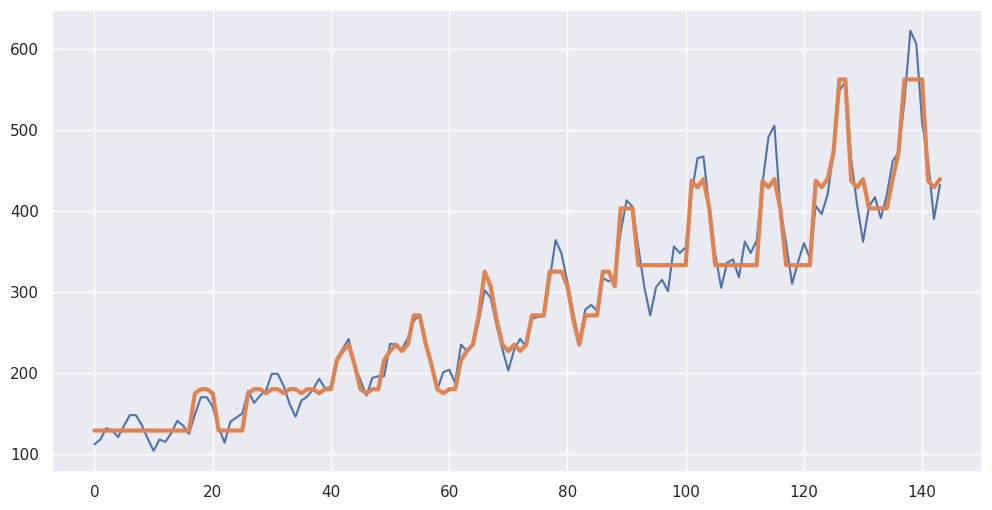

In [21]:
model = GaussianHMM(n_components=20,
                        covariance_type="diag",
                        n_iter=1000)
model.fit(values)
labels = model.predict(values)
means = np.zeros_like(values)
for i in range(model.n_components):
    means[labels == i] = model.means_[i]
    
plt.figure(figsize=(12, 6))
plt.plot(values)
plt.plot(means, linewidth=3)

### 7. Попробуйте построить через среднее каждой компоненты наивный прогноз ряда.

In [22]:
# строю модель с 10 компонентами
model10 = GaussianHMM(n_components=10, covariance_type="diag", n_iter=1000)
model10.fit(values)
labels10 = model10.predict(values)
means10 = np.zeros_like(values)
for i in range(model10.n_components):
    means10[labels10 == i] = model10.means_[i]


In [23]:
# строю модель с 30 компонентами
model30 = GaussianHMM(n_components=30, covariance_type="diag", n_iter=1000)
model30.fit(values)
labels30 = model30.predict(values)
means30 = np.zeros_like(values)
for i in range(model30.n_components):
    means30[labels30 == i] = model30.means_[i]


Fitting a model with 959 free scalar parameters with only 144 data points will result in a degenerate solution.


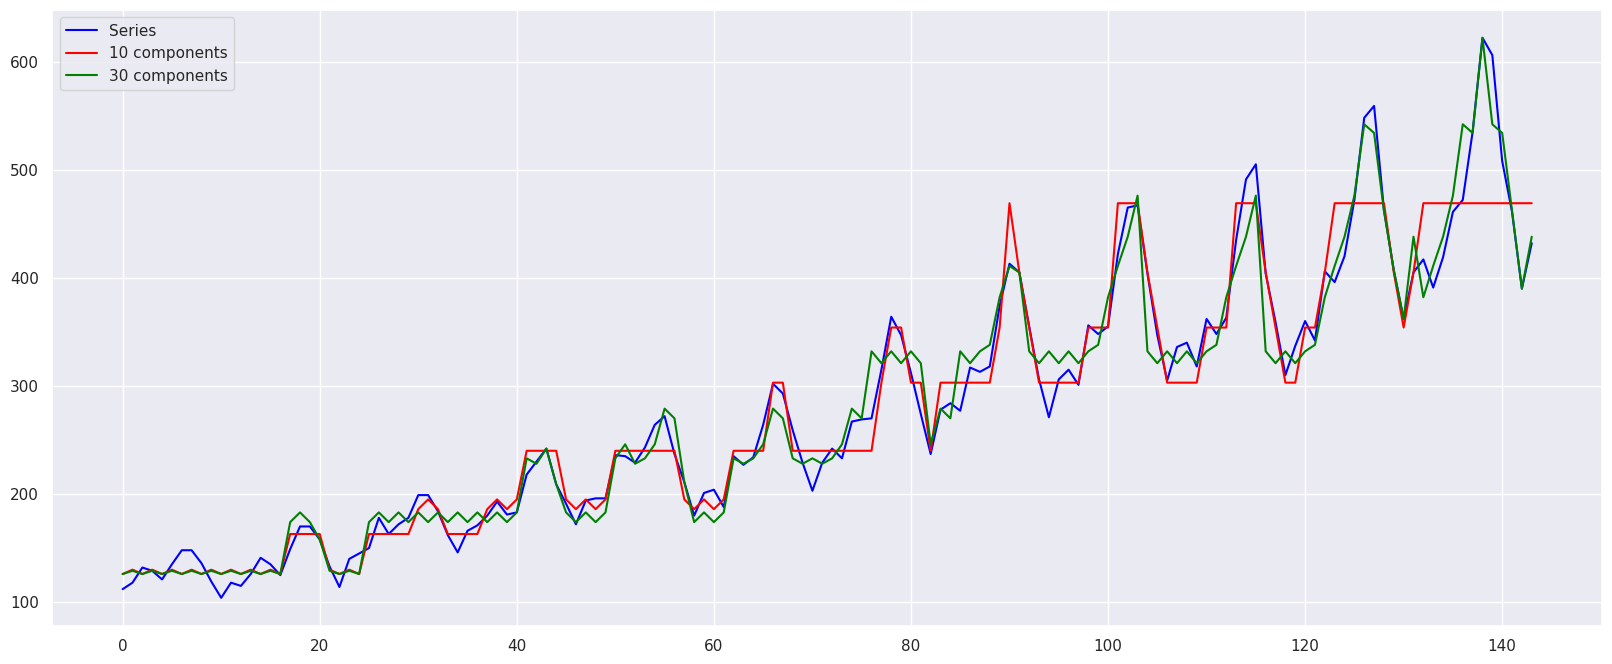

In [24]:
# строю график
plt.figure(figsize=(20, 8))
plt.plot(values, color='blue', label='Series')
plt.plot(means10, color='red', label='10 components')
plt.plot(means30, color='green', label='30 components')
plt.legend()

##### строю предсказание по 10 и 30 компонентам
##### как видно на графике ниже, чем больше компонент, тем точнее предсказание показывает модель
##### хотя в обоих случаях далеко от идеала

In [25]:
def hmm_predict(labels, model, n_comp, n_preds=10):
    cur_value = labels[-1]
    predictions = []
    for _ in range(n_preds):
        cur_value = np.random.choice(n_comp, p=model.transmat_[cur_value])
        predictions.append(model.means_[cur_value])
    return predictions

In [26]:
pred10 = np.concatenate((values, hmm_predict(labels10, model10, 10)))
pred30 = np.concatenate((values, hmm_predict(labels30, model30, 30)))

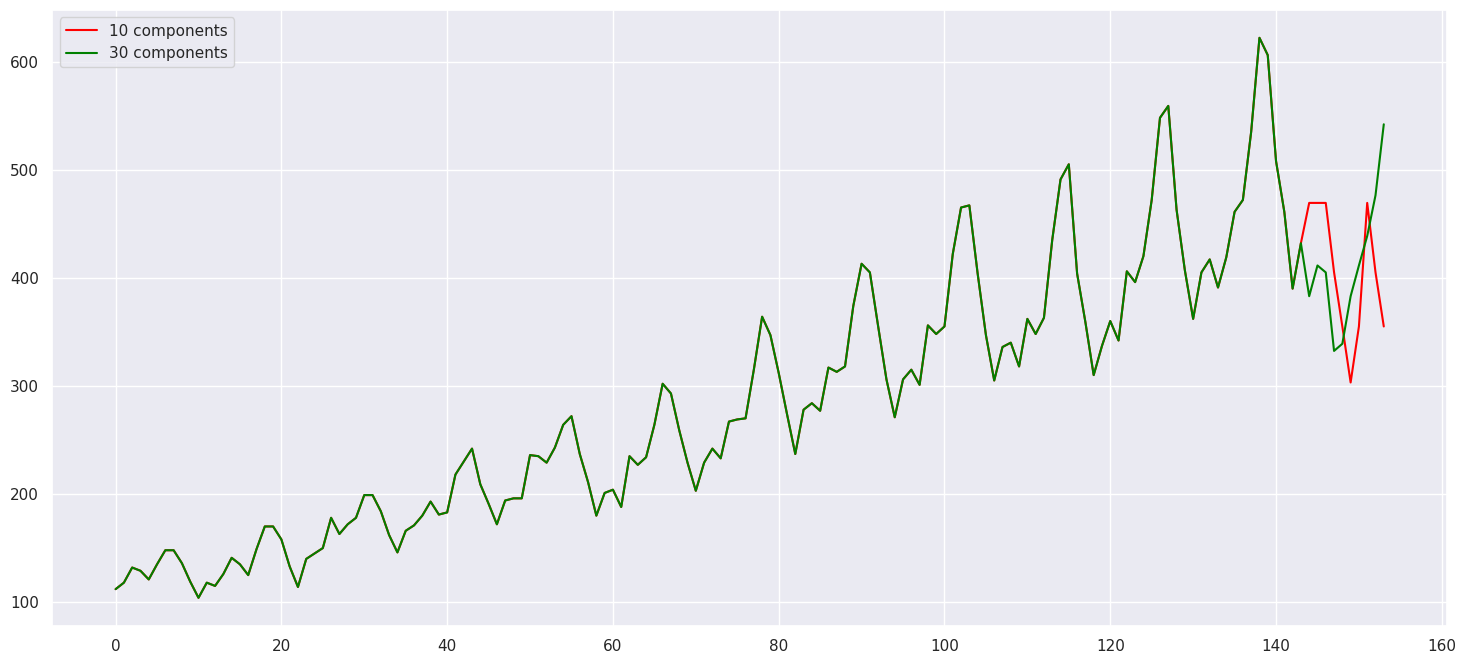

In [27]:
plt.figure(figsize=(18, 8))
plt.plot(pred10, color='red', label='10 components')
plt.plot(pred30, color='green', label='30 components')
plt.legend()